In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.impute import SimpleImputer

In [2]:
# Эта функция скопирована из задания 4
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_true, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [1, 0], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [3]:
# Предобработка данных (и тренировочных, и тестовых)

df_train = pd.read_csv('TrainSample.csv')
df_test = pd.read_csv('TestSample.csv')

target = 'INS'
nominal_features = ['BRANCH', 'id', 'PHONE', 'RES']
binary_features = ['ATM', 'CC', 'CD', 'DDA', 'DIRDEP', 'HMOWN', 'ILS', 'INAREA', 'INV', 
                   'IRA', 'LOC', 'MM', 'MOVED', 'MTG', 'NSF', 'SAV', 'SDB']
interval_features = list(set(df_train.columns) - {target} - 
                         set(nominal_features) - set(binary_features))

# Удаляем номинальные переменные, так как с ними сложно работать
df_train.drop(columns=nominal_features, inplace=True)
df_test.drop(columns=nominal_features, inplace=True)

y_train = df_train[target]
y_test = df_test[target]
X_train = df_train.loc[:, sorted(list(set(df_train.columns) - {target}))]
X_test = df_test.loc[:, sorted(list(set(df_test.columns) - {target}))]

In [4]:
# Заполняем пропущенные значения (NaN) самыми частыми значениями в колонке
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train = pd.DataFrame(imp.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(imp.fit_transform(X_test), columns=X_test.columns)

In [5]:
# Преобразуем данные, чтобы распределения интервальных переменных стали ближе к нормальным
pt = PowerTransformer()
X_train[interval_features] = pt.fit_transform(X_train[interval_features])
X_test[interval_features] = pt.transform(X_test[interval_features])

In [6]:
# Делим тренировочную выборку ещё на две, чтобы проверять качество алгоритма
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=1)

In [7]:
# Эксперименты показали, что модели регрессии дают более лучшие результаты, 
# несмотря на то что наша задача является задачей бинарной классификации

In [8]:
# Рассмотрим модель Linear Support Vector Regression
# Подбираем оптимальное значение epsilon в смысле максимизации roc_auc_score
params = {'epsilon': np.arange(0, 0.6, 0.1),
          'max_iter': [5000],
          'tol': [1e-2],
          'random_state': [1]}
model = GridSearchCV(LinearSVR(), params, scoring=make_scorer(roc_auc_score)).fit(X_train, y_train)

In [9]:
# На валидационном наборе значение ROC AUC хорошее (больше 0.777)
roc_auc_score(y_val, model.predict(X_val))

0.7819000386901622

In [10]:
# На тестовом наборе тоже хорошее значение
# Заметим, что тестовый набор не использовался в обучении - только в предобработке
roc_auc_score(y_test, model.predict(X_test))

0.7782596884617801

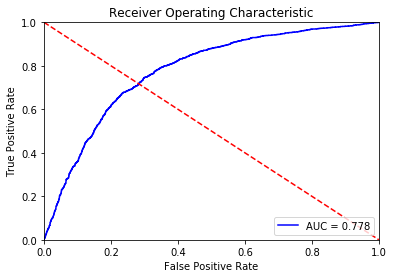

In [11]:
plot_roc_curve(y_test, model.predict(X_test))